In [ ]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python", "scikit-image", "scikit-learn",]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from tensorflow import keras
import torch
import cv2

/opt/conda/bin/python3.10
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python
Installing: scikit-image
Installing: scikit-learn


2024-05-26 14:53:43.501701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 14:53:43.501821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 14:53:43.659889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import pandas as pd
import torch.nn as nn
from tqdm import tqdm

# Задание 1

Обучить CNN для классификации на данных «Cassava Leaf Disease Classification»

## 1.1 Подготовка данных

Сперва необходимо считать данные из директории и представить их в объекте для обучения.

В данном задании в качестве обертки для датасета был выбран объект Dataset из фреймворка Tensorflow, поскольку с ним удобно работать в том случае, когда директория изображений не соответствует меткам классов (а они находятся отдельно).

Получим данные о метках изображений.

In [ ]:
df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv', sep=',')
df

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

Создадим словарь, содержащий информацию о соответствии номера класса к его названию.

In [ ]:
id2class = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

Выделим отдельно метки классов.

In [ ]:
Y = df.label.to_list()
len(Y)

21397

Создадим обучающую и тестовую выборки при помощи tensorflow.

In [ ]:
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/cassava-leaf-disease-classification/train_images",
    validation_split=0.2,
    labels=list(Y),
    label_mode="int",
    subset="both",
    image_size=(600, 800),
    batch_size=32,
    seed=13
)

Found 21397 files belonging to 5 classes.
Using 17118 files for training.
Using 4279 files for validation.


## 1.2 Трансформирование данных

Поскольку исходный размер изображений (600 на 800 пикселей) очень большой (это создаст проблемы при обучении), уменьшим его в 4 раза.

In [ ]:
transformation = keras.Sequential([
    keras.layers.Resizing(150, 200),
    keras.layers.Rescaling(1. / 255)
])

In [ ]:
base_train_ds = train_ds.map(lambda img, label: (transformation(img), label))

In [ ]:
test_ds = test_ds.map(lambda img, label: (transformation(img), label))

Визуализируем датасет.

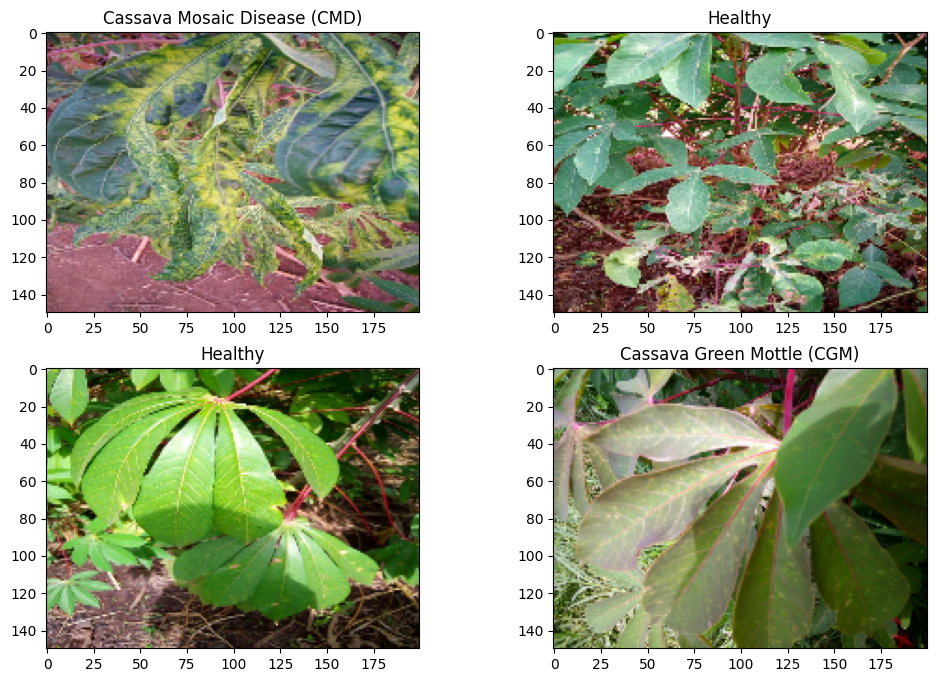

In [ ]:
for data in base_train_ds:
    X = data[0]
    y = data[1]

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    ax[0, 0].imshow(X[0].numpy())
    ax[0, 0].set_title(id2class[y[0].numpy()])

    ax[0, 1].imshow(X[1].numpy())
    ax[0, 1].set_title(id2class[y[1].numpy()])

    ax[1, 0].imshow(X[2].numpy())
    ax[1, 0].set_title(id2class[y[2].numpy()])

    ax[1, 1].imshow(X[3].numpy())
    ax[1, 1].set_title(id2class[y[3].numpy()])

    break

## 1.3 Аугментация

Подготовим аугментированный датасет.

In [ ]:
augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
])

In [ ]:
augmentation_train_ds = base_train_ds.map(lambda img, label: (augmentation(img), label))

Визуализация датасета.

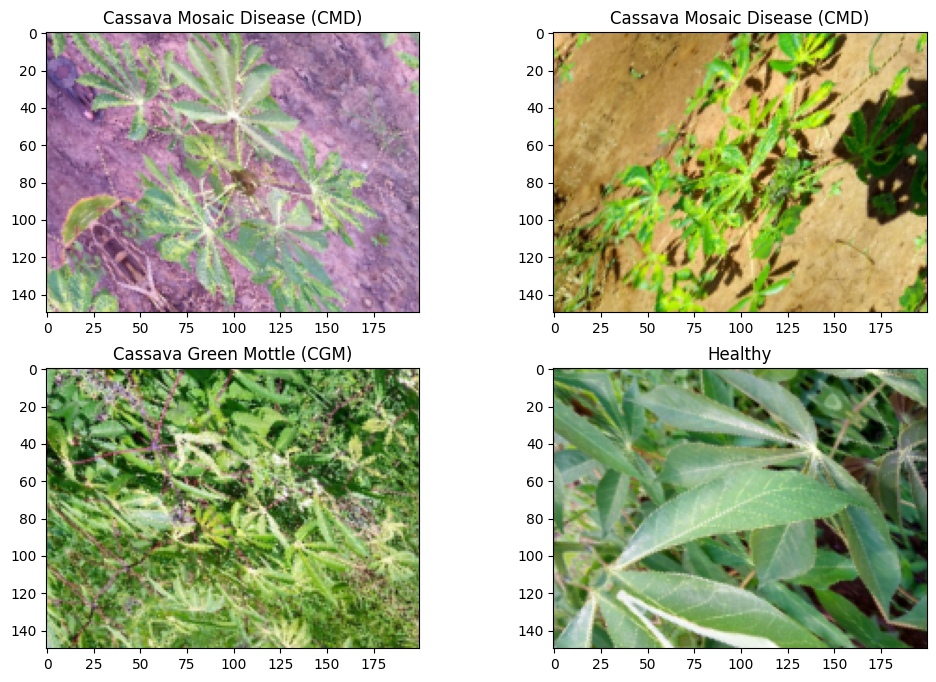

In [ ]:
for data in augmentation_train_ds:
    X = data[0]
    y = data[1]

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    ax[0, 0].imshow(X[0].numpy())
    ax[0, 0].set_title(id2class[y[0].numpy()])

    test_image = X[0].numpy()

    ax[0, 1].imshow(X[1].numpy())
    ax[0, 1].set_title(id2class[y[1].numpy()])

    ax[1, 0].imshow(X[2].numpy())
    ax[1, 0].set_title(id2class[y[2].numpy()])

    ax[1, 1].imshow(X[3].numpy())
    ax[1, 1].set_title(id2class[y[3].numpy()])

    break

## 1.4 Построение базовой модели

## 1.5 Процесс обучения

Для обозначения эксперимента будем пользоваться следующей системой обозначений.

«+» обозначает, что определенная технология используется. В свою очередь, «-» обозначает, что не используется.

Аугментация = aug.

Использование шедоулера = sh.

In [ ]:
from keras.callbacks import History

In [ ]:
epoch_number = 10

### 1.5.1 -aug & sgd & -sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
history = History()

In [ ]:
lr = 0.001

model.compile(
    optimizer=keras.optimizers.SGD(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
model.fit(
    x=base_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
  4/535 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.1250 - loss: 2.9042 

I0000 00:00:1716551305.213331     177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


535/535 ━━━━━━━━━━━━━━━━━━━━ 106s 188ms/step - accuracy: 0.5460 - loss: 1.3226 - val_accuracy: 0.6181 - val_loss: 1.1873
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.6140 - loss: 1.1210 - val_accuracy: 0.6291 - val_loss: 1.0933
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 140ms/step - accuracy: 0.6208 - loss: 1.0802 - val_accuracy: 0.6378 - val_loss: 1.0510
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - accuracy: 0.6269 - loss: 1.0418 - val_accuracy: 0.6371 - val_loss: 1.0312
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - accuracy: 0.6291 - loss: 1.0213 - val_accuracy: 0.6324 - val_loss: 1.0663
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.6354 - loss: 1.0005 - val_accuracy: 0.5268 - val_loss: 1.2486
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - accuracy: 0.6405 - loss: 0.9799 - val_accuracy: 0.6424 - val_loss: 1.0022
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - accuracy: 0.6420 - loss: 0.9618 - va

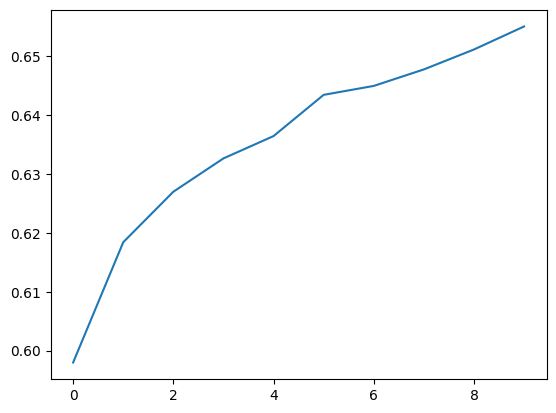

In [ ]:
plt.plot(history.history['accuracy'])

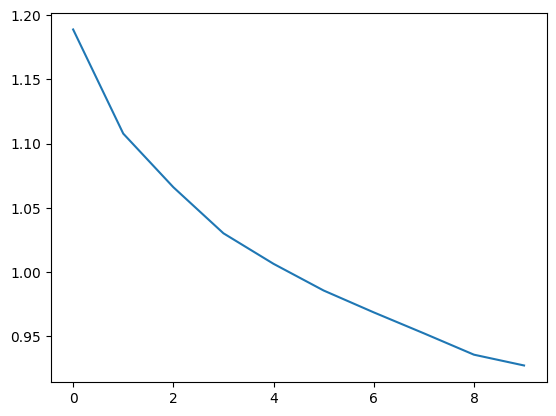

In [ ]:
plt.plot(history.history['loss'])

### 1.5.2 -aug & sgd & +sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
lr = 0.001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=base_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 79s 141ms/step - accuracy: 0.5820 - loss: 1.2468 - val_accuracy: 0.6195 - val_loss: 1.1730
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 74s 138ms/step - accuracy: 0.6165 - loss: 1.1277 - val_accuracy: 0.6233 - val_loss: 1.1187
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - accuracy: 0.6180 - loss: 1.1151 - val_accuracy: 0.6242 - val_loss: 1.1110
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 140ms/step - accuracy: 0.6184 - loss: 1.1084 - val_accuracy: 0.6261 - val_loss: 1.1068
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 138ms/step - accuracy: 0.6208 - loss: 1.1006 - val_accuracy: 0.6261 - val_loss: 1.1039
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 139ms/step - accuracy: 0.6211 - loss: 1.1005 - val_accuracy: 0.6261 - val_loss: 1.1031
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - accuracy: 0.6214 - loss: 1.0981 - val_accuracy: 0.6263 - val_loss: 1.1023
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.6217 - loss: 1

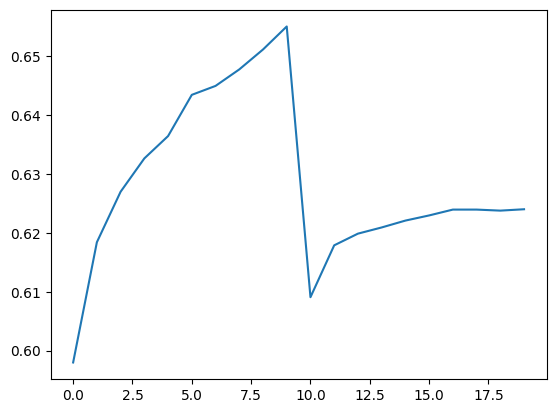

In [ ]:
plt.plot(history.history['accuracy'])

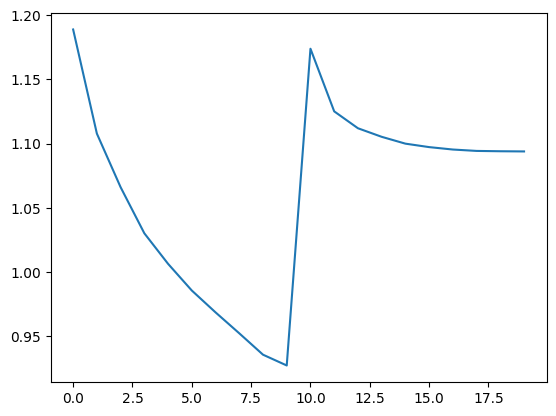

In [ ]:
plt.plot(history.history['loss'])

### 1.5.3 -aug & rms & -sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
history = History()

lr = 0.001

model.compile(
    optimizer=keras.optimizers.RMSprop(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=base_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.6003 - loss: 1.2024 - val_accuracy: 0.4188 - val_loss: 1.4426
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6309 - loss: 1.0170 - val_accuracy: 0.6319 - val_loss: 1.5644
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.6433 - loss: 0.9650 - val_accuracy: 0.6441 - val_loss: 1.0410
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - accuracy: 0.6537 - loss: 0.9395 - val_accuracy: 0.1968 - val_loss: 2.1730
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6622 - loss: 0.9138 - val_accuracy: 0.6434 - val_loss: 1.1289
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - accuracy: 0.6664 - loss: 0.8985 - val_accuracy: 0.5062 - val_loss: 1.3449
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.6666 - loss: 0.8863 - val_accuracy: 0.6340 - val_loss: 1.2893
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6671 - loss: 0

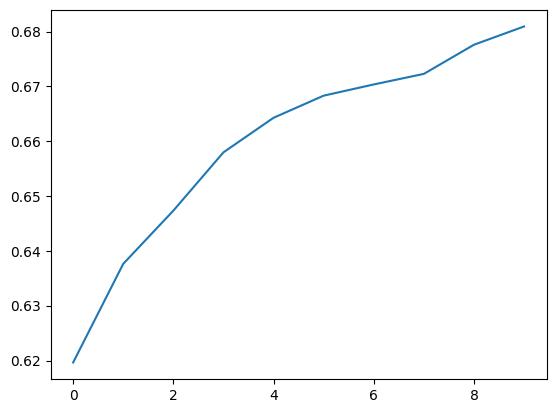

In [ ]:
plt.plot(history.history['accuracy'])

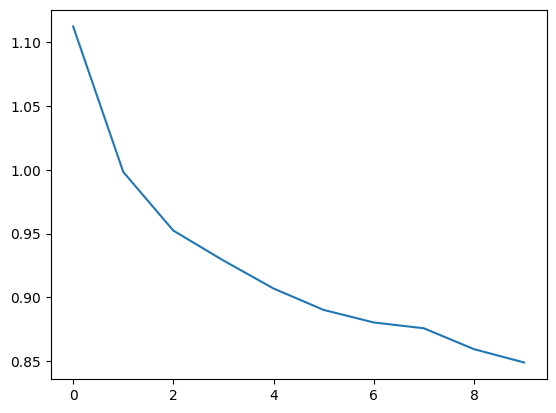

In [ ]:
plt.plot(history.history['loss'])

### 1.5.4 -aug & rms & +sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
lr = 0.001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=base_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.6108 - loss: 1.1381 - val_accuracy: 0.6338 - val_loss: 1.0398
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - accuracy: 0.6293 - loss: 1.0105 - val_accuracy: 0.6443 - val_loss: 0.9840
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6419 - loss: 0.9580 - val_accuracy: 0.5529 - val_loss: 1.1887
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - accuracy: 0.6509 - loss: 0.9330 - val_accuracy: 0.6581 - val_loss: 0.9285
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6590 - loss: 0.9110 - val_accuracy: 0.6530 - val_loss: 0.9650
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - accuracy: 0.6634 - loss: 0.9042 - val_accuracy: 0.6660 - val_loss: 0.9231
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6657 - loss: 0.9009 - val_accuracy: 0.6658 - val_loss: 0.9156
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - accuracy: 0.6654 - loss: 0

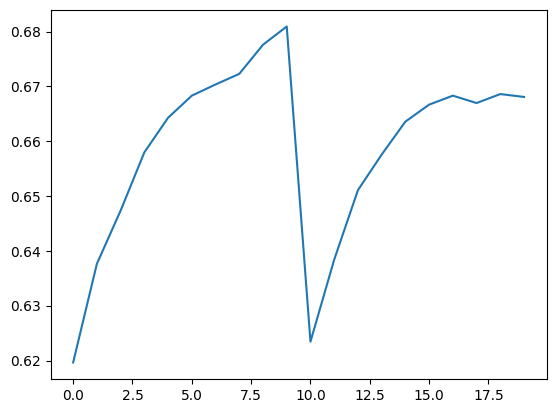

In [ ]:
plt.plot(history.history['accuracy'])

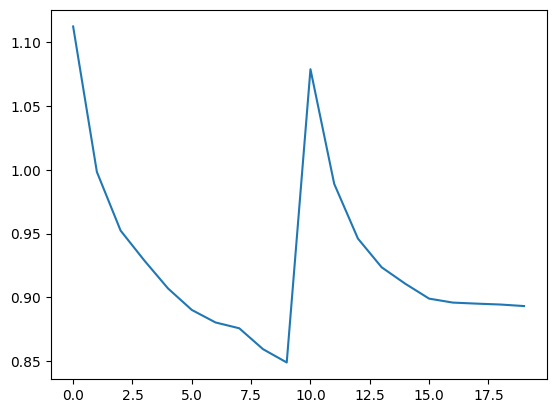

In [ ]:
plt.plot(history.history['loss'])

### 1.5.5 -aug & adam & -sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
history = History()

lr = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=base_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 84s 148ms/step - accuracy: 0.5971 - loss: 1.1950 - val_accuracy: 0.6310 - val_loss: 1.1122
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - accuracy: 0.6220 - loss: 1.0768 - val_accuracy: 0.2645 - val_loss: 1.6878
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6345 - loss: 1.0043 - val_accuracy: 0.3026 - val_loss: 1.7242
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - accuracy: 0.6467 - loss: 0.9577 - val_accuracy: 0.6562 - val_loss: 0.9742
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6505 - loss: 0.9272 - val_accuracy: 0.6443 - val_loss: 0.9662
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 78s 145ms/step - accuracy: 0.6600 - loss: 0.9078 - val_accuracy: 0.6457 - val_loss: 1.0570
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6632 - loss: 0.8897 - val_accuracy: 0.6459 - val_loss: 1.0311
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.6628 - loss: 0

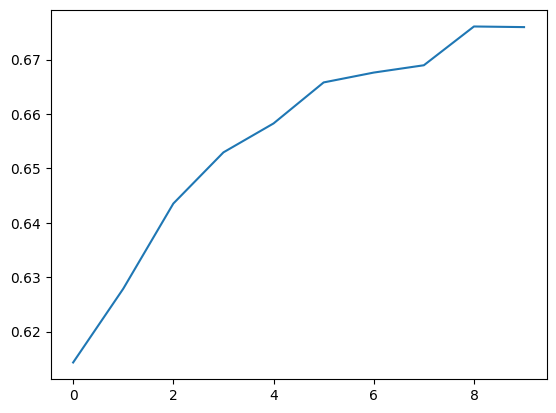

In [ ]:
plt.plot(history.history['accuracy'])

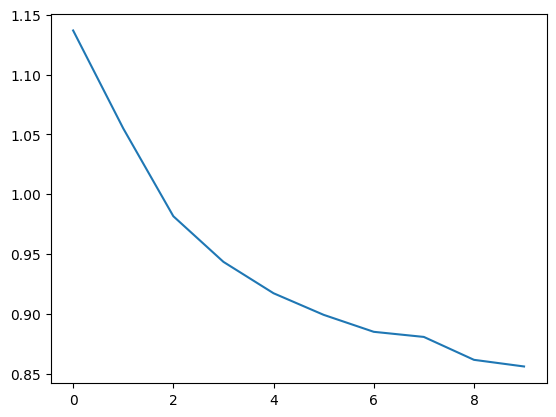

In [ ]:
plt.plot(history.history['loss'])

### 1.5.6 -aug & adam & +sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
lr = 0.001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=base_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 83s 145ms/step - accuracy: 0.5977 - loss: 1.1793 - val_accuracy: 0.6228 - val_loss: 1.0656
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - accuracy: 0.6342 - loss: 1.0203 - val_accuracy: 0.5613 - val_loss: 1.2118
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - accuracy: 0.6489 - loss: 0.9661 - val_accuracy: 0.6375 - val_loss: 1.0403
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6501 - loss: 0.9419 - val_accuracy: 0.6558 - val_loss: 0.9477
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6594 - loss: 0.9193 - val_accuracy: 0.6448 - val_loss: 1.0070
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - accuracy: 0.6613 - loss: 0.9123 - val_accuracy: 0.6614 - val_loss: 0.9306
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - accuracy: 0.6687 - loss: 0.9024 - val_accuracy: 0.6616 - val_loss: 0.9224
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 76s 140ms/step - accuracy: 0.6681 - loss: 0

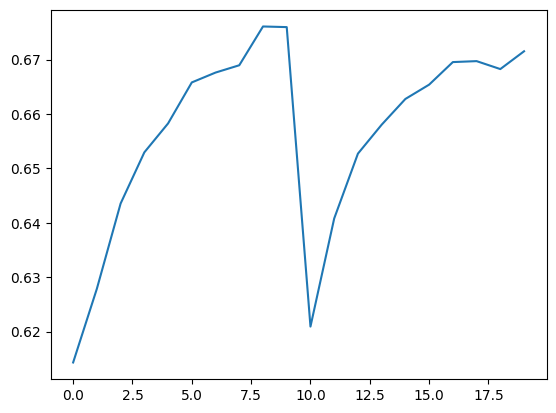

In [ ]:
plt.plot(history.history['accuracy'])

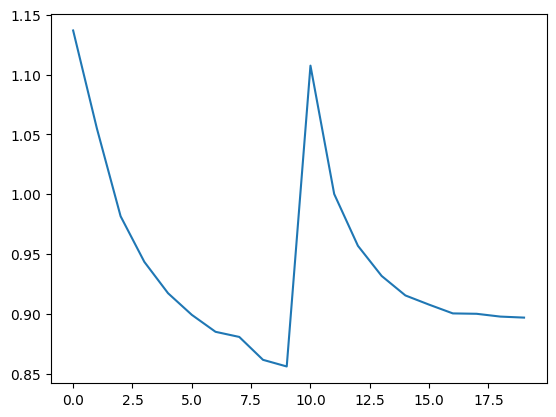

In [ ]:
plt.plot(history.history['loss'])

### 1.5.7 +aug & sgd & -sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
history = History()

lr = 0.001

model.compile(
    optimizer=keras.optimizers.SGD(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=augmentation_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 131s 238ms/step - accuracy: 0.5978 - loss: 1.1995 - val_accuracy: 0.6268 - val_loss: 1.1739
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 126s 234ms/step - accuracy: 0.6184 - loss: 1.1096 - val_accuracy: 0.6268 - val_loss: 1.1593
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 235ms/step - accuracy: 0.6189 - loss: 1.0872 - val_accuracy: 0.6359 - val_loss: 1.0680
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 126s 234ms/step - accuracy: 0.6234 - loss: 1.0693 - val_accuracy: 0.6249 - val_loss: 1.2578
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 235ms/step - accuracy: 0.6229 - loss: 1.0553 - val_accuracy: 0.6378 - val_loss: 1.0866
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 236ms/step - accuracy: 0.6234 - loss: 1.0331 - val_accuracy: 0.6315 - val_loss: 1.1963
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6264 - loss: 1.0135 - val_accuracy: 0.6294 - val_loss: 1.1284
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6336 -

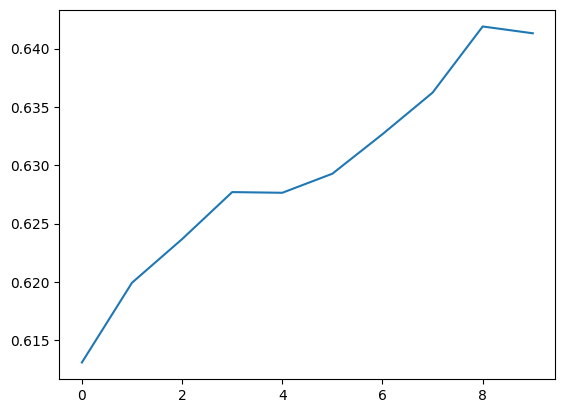

In [ ]:
plt.plot(history.history['accuracy'])

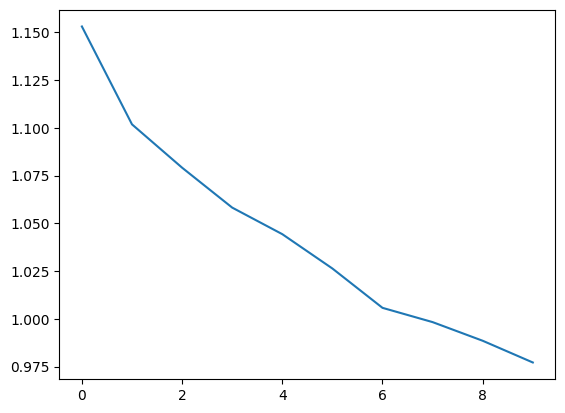

In [ ]:
plt.plot(history.history['loss'])

### 1.5.8 +aug & sgd & +sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
lr = 0.001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=augmentation_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 232ms/step - accuracy: 0.6051 - loss: 1.1917 - val_accuracy: 0.6202 - val_loss: 1.1288
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6147 - loss: 1.1402 - val_accuracy: 0.6184 - val_loss: 1.1763
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 125s 232ms/step - accuracy: 0.6154 - loss: 1.1277 - val_accuracy: 0.6240 - val_loss: 1.1393
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 125s 232ms/step - accuracy: 0.6151 - loss: 1.1169 - val_accuracy: 0.6254 - val_loss: 1.1380
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 236ms/step - accuracy: 0.6180 - loss: 1.1171 - val_accuracy: 0.6256 - val_loss: 1.1291
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 229ms/step - accuracy: 0.6161 - loss: 1.1124 - val_accuracy: 0.6256 - val_loss: 1.1291
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6205 - loss: 1.1073 - val_accuracy: 0.6256 - val_loss: 1.1288
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6176 -

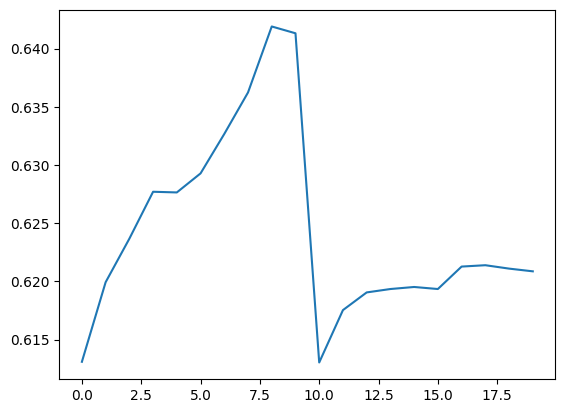

In [ ]:
plt.plot(history.history['accuracy'])

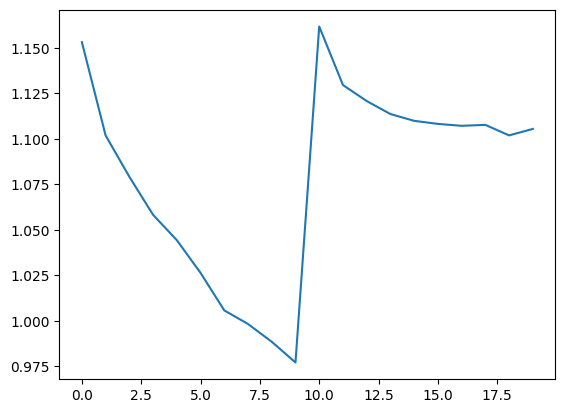

In [ ]:
plt.plot(history.history['loss'])

### 1.5.9 +aug & rms & -sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
history = History()

lr = 0.001

model.compile(
    optimizer=keras.optimizers.RMSprop(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=augmentation_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 127s 230ms/step - accuracy: 0.6031 - loss: 1.1913 - val_accuracy: 0.6219 - val_loss: 1.2126
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6249 - loss: 1.0478 - val_accuracy: 0.6523 - val_loss: 1.0104
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 142s 230ms/step - accuracy: 0.6410 - loss: 0.9979 - val_accuracy: 0.6394 - val_loss: 1.4025
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6433 - loss: 0.9788 - val_accuracy: 0.5513 - val_loss: 1.1753
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 228ms/step - accuracy: 0.6486 - loss: 0.9637 - val_accuracy: 0.6450 - val_loss: 1.0039
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 126s 235ms/step - accuracy: 0.6496 - loss: 0.9571 - val_accuracy: 0.3501 - val_loss: 1.5845
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6537 - loss: 0.9434 - val_accuracy: 0.6621 - val_loss: 0.9659
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 229ms/step - accuracy: 0.6548 -

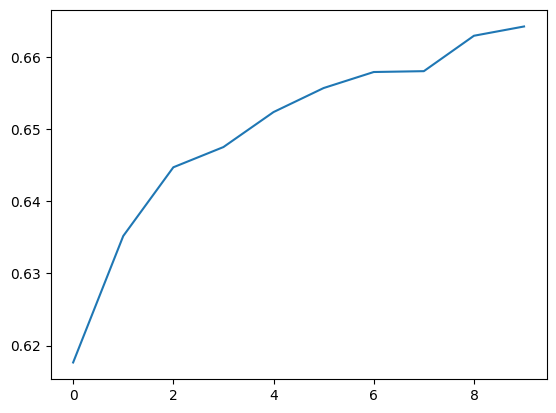

In [ ]:
plt.plot(history.history['accuracy'])

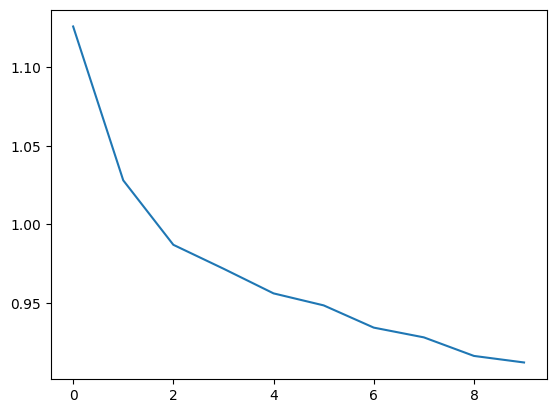

In [ ]:
plt.plot(history.history['loss'])

### 1.5.10 +aug & rms & +sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
lr = 0.001

history = History()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=augmentation_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 129s 235ms/step - accuracy: 0.5997 - loss: 1.1927 - val_accuracy: 0.6324 - val_loss: 1.0878
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6231 - loss: 1.0718 - val_accuracy: 0.6032 - val_loss: 1.1015
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 126s 234ms/step - accuracy: 0.6343 - loss: 1.0052 - val_accuracy: 0.6551 - val_loss: 0.9740
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 126s 234ms/step - accuracy: 0.6439 - loss: 0.9843 - val_accuracy: 0.6357 - val_loss: 1.0914
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6477 - loss: 0.9679 - val_accuracy: 0.6308 - val_loss: 1.2049
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6511 - loss: 0.9595 - val_accuracy: 0.6495 - val_loss: 1.0117
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6517 - loss: 0.9541 - val_accuracy: 0.6525 - val_loss: 0.9983
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 229ms/step - accuracy: 0.6533 -

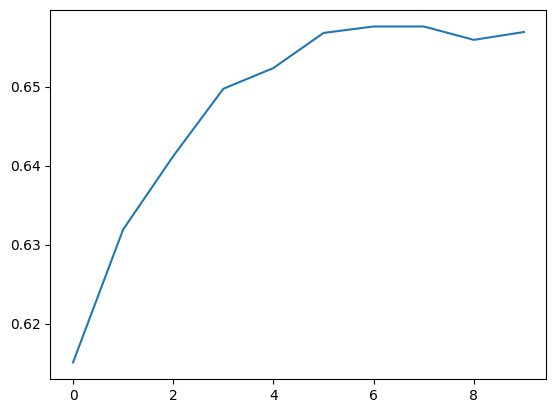

In [ ]:
plt.plot(history.history['accuracy'])

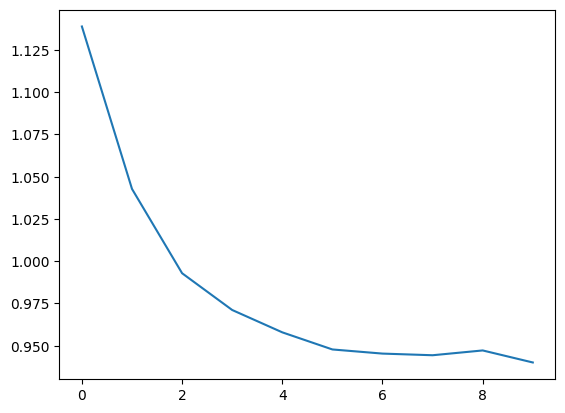

In [ ]:
plt.plot(history.history['loss'])

### 1.5.11 +aug & adam & -sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
history = History()

lr = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=augmentation_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 130s 234ms/step - accuracy: 0.6097 - loss: 1.1571 - val_accuracy: 0.6200 - val_loss: 1.8356
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 125s 232ms/step - accuracy: 0.6330 - loss: 1.0188 - val_accuracy: 0.6541 - val_loss: 0.9581
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6416 - loss: 0.9752 - val_accuracy: 0.6555 - val_loss: 1.0071
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 125s 232ms/step - accuracy: 0.6525 - loss: 0.9462 - val_accuracy: 0.6118 - val_loss: 1.0508
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6514 - loss: 0.9370 - val_accuracy: 0.6424 - val_loss: 0.9881
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 125s 233ms/step - accuracy: 0.6618 - loss: 0.9150 - val_accuracy: 0.6773 - val_loss: 0.8946
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6606 - loss: 0.9117 - val_accuracy: 0.2839 - val_loss: 1.8765
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6634 -

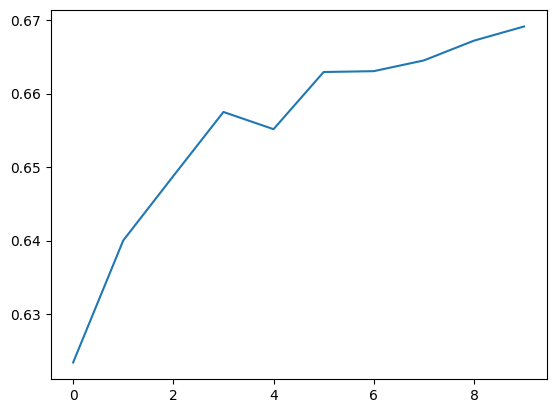

In [ ]:
plt.plot(history.history['accuracy'])

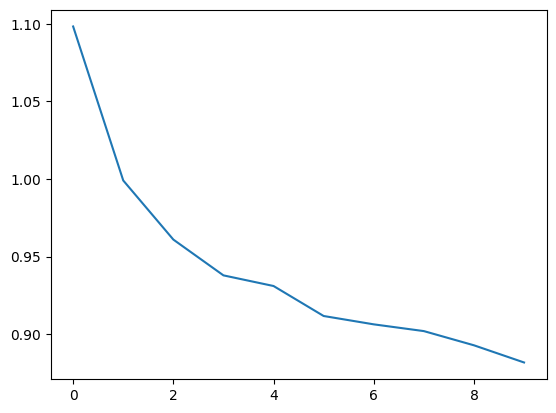

In [ ]:
plt.plot(history.history['loss'])

### 1.5.12 +aug & adam & +sh

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=15, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=9, strides=4, padding='same'),

    keras.layers.Conv2D(filters=6, kernel_size=11, strides=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=5, strides=4, padding='same'),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(5, activation="softmax")
])

In [ ]:
lr = 0.001

history = History()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    x=augmentation_train_ds,
    epochs=epoch_number,
    validation_data=test_ds,
    callbacks=[history]
)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 130s 233ms/step - accuracy: 0.6024 - loss: 1.1765 - val_accuracy: 0.4945 - val_loss: 1.3510
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 231ms/step - accuracy: 0.6295 - loss: 1.0254 - val_accuracy: 0.4197 - val_loss: 1.4012
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6451 - loss: 0.9822 - val_accuracy: 0.6464 - val_loss: 1.0039
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6493 - loss: 0.9563 - val_accuracy: 0.6396 - val_loss: 1.0983
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 229ms/step - accuracy: 0.6569 - loss: 0.9453 - val_accuracy: 0.6674 - val_loss: 0.9421
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 122s 226ms/step - accuracy: 0.6568 - loss: 0.9311 - val_accuracy: 0.6660 - val_loss: 0.9551
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 123s 230ms/step - accuracy: 0.6621 - loss: 0.9205 - val_accuracy: 0.6719 - val_loss: 0.9254
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 124s 230ms/step - accuracy: 0.6624 -

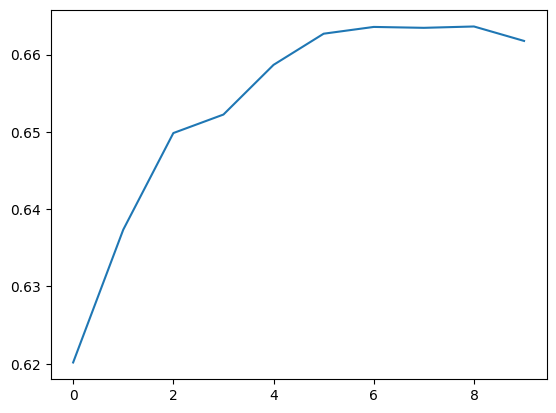

In [ ]:
plt.plot(history.history['accuracy'])

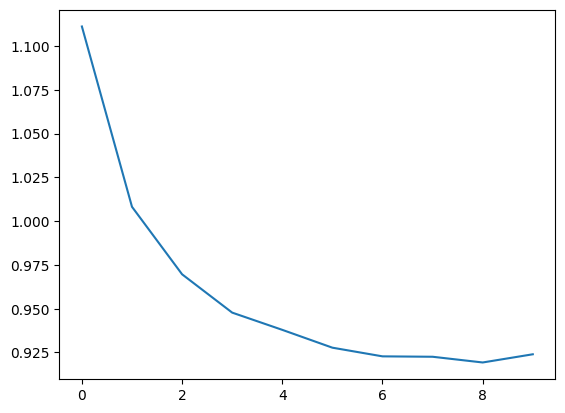

In [ ]:
plt.plot(history.history['loss'])

### 1.5.13 VGG & -aug & adam & -sh

Подготовим данные для vgg (чтобы совпадал входной размер изображения)

In [ ]:
epoch_number = 10

In [ ]:
transformation = keras.Sequential([
    keras.layers.Resizing(224, 224),
    keras.layers.Rescaling(1. / 255)
])

In [ ]:
vgg_train_ds = train_ds.map(lambda img, label: (transformation(img), label))

In [ ]:
vgg_test_ds = vgg_train_ds.map(lambda img, label: (transformation(img), label))

In [ ]:
test_image = None

In [ ]:
for data in vgg_test_ds:
    X = data[0]

    test_image = X[0].numpy()

    break

In [ ]:
test_image.shape

(224, 224, 3)

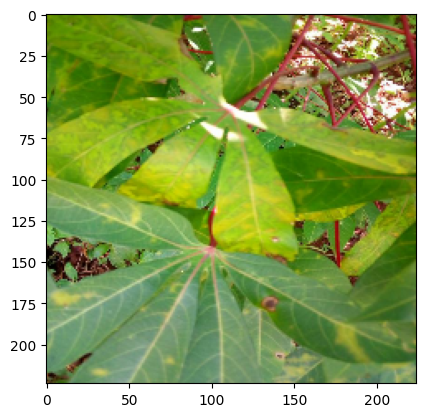

In [ ]:
plt.imshow(test_image * 255)

Получим модель vgg и разморозим слои

In [ ]:
vgg = keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input = vgg.input
my_layer = keras.layers.Dense(5, activation='softmax')
output = my_layer(vgg.layers[-2].output)

my_vgg = keras.Model(input, output)

In [ ]:
lr = 0.001

optimizer = keras.optimizers.Adam(learning_rate=lr)

my_vgg.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
for layer in my_vgg.layers:
    layer.trainable = False
my_vgg.layers[-1].trainable = True

In [ ]:
history = History()

my_vgg.fit(
    x=vgg_train_ds,
    epochs=epoch_number,
    validation_data=vgg_test_ds,
    callbacks=[history]
)

Epoch 1/10


2024-05-24 15:11:39.646477: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-24 15:11:39.646531: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-24 15:11:39.646541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-24 15:11:39.646548: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-24 15:11:39.646556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-24 15:11:39.646563: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-24 15:11:39.646571: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-24 15:11:39.646578: E external/local_xla/xla/se

  2/535 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.4219 - loss: 1.5136   

W0000 00:00:1716563515.163854     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


534/535 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6113 - loss: 1.1370

2024-05-24 15:13:04.469646: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 5.1593, expected 4.2307
2024-05-24 15:13:04.469704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.27465, expected 4.34605
2024-05-24 15:13:04.469722: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 6.22507, expected 5.29647
2024-05-24 15:13:04.469741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.11698, expected 5.18838
2024-05-24 15:13:04.469753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.57882, expected 4.65022
2024-05-24 15:13:04.469764: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.26032, expected 4.33172
2024-05-24 15:13:04.469774: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.05778, expected 4.12918
2024-05-24 15:13:04.469784: E

535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6113 - loss: 1.1368

W0000 00:00:1716563598.092395     175 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716563600.091565     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 173s 290ms/step - accuracy: 0.6113 - loss: 1.1367 - val_accuracy: 0.1026 - val_loss: 1.5432
Epoch 2/10


W0000 00:00:1716563669.780281     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


535/535 ━━━━━━━━━━━━━━━━━━━━ 147s 273ms/step - accuracy: 0.6437 - loss: 1.0201 - val_accuracy: 0.1209 - val_loss: 2.2811
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 136s 253ms/step - accuracy: 0.6495 - loss: 0.9925 - val_accuracy: 0.1209 - val_loss: 2.5317
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 136s 252ms/step - accuracy: 0.6536 - loss: 0.9685 - val_accuracy: 0.1209 - val_loss: 2.5533
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 138s 257ms/step - accuracy: 0.6593 - loss: 0.9575 - val_accuracy: 0.1209 - val_loss: 1.9105
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 136s 253ms/step - accuracy: 0.6577 - loss: 0.9604 - val_accuracy: 0.1209 - val_loss: 2.6140
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 138s 258ms/step - accuracy: 0.6622 - loss: 0.9425 - val_accuracy: 0.1209 - val_loss: 2.5309
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 138s 257ms/step - accuracy: 0.6640 - loss: 0.9391 - val_accuracy: 0.1209 - val_loss: 2.5895
Epoch 9/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 137s 255ms/step - accuracy: 0.6716 - loss: 0.91

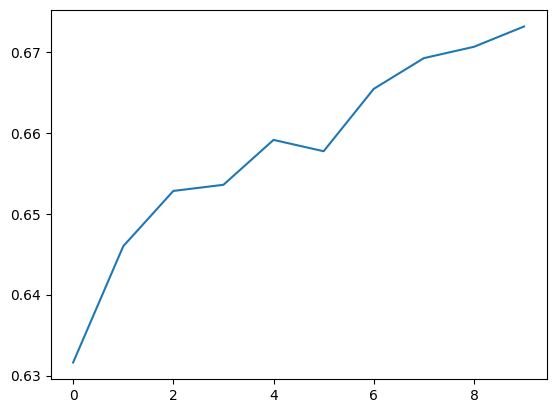

In [ ]:
plt.plot(history.history['accuracy'])

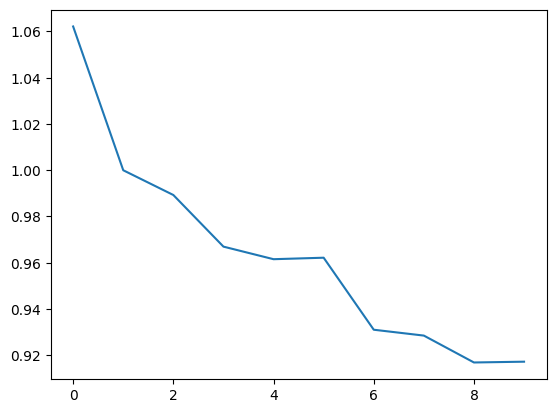

In [ ]:
plt.plot(history.history['loss'])

## 1.6 Описание эксперимента

| Название эксперимента               | train accuracy | test accuracy |
| ----------------------------------- | -------------- | ------------- |
| -aug &amp; sgd &amp; -sh            | 0.6485         | 0.6523        |
| -aug &amp; sgd &amp; +sh            | 0.6209         | 0.6258        |
| -aug &amp; rms &amp; -sh            | 0.6783         | 0.6336        |
| -aug &amp; rms &amp; +sh            | 0.6675         | 0.6660        |
| -aug &amp; adam &amp; -sh           | 0.6693         | 0.6726        |
| -aug &amp; adam &amp; +sh           | 0.6693         | 0.6625        |
| +aug &amp; sgd &amp; -sh            | 0.6384         | 0.6263        |
| +aug &amp; sgd &amp; +sh            | 0.6178         | 0.6258        |
| +aug &amp; rms &amp; -sh            | 0.6613         | 0.3982        |
| +aug &amp; rms &amp; +sh            | 0.6532         | 0.6555        |
| +aug &amp; adam &amp; -sh           | 0.6646         | 0.6738        |
| +aug &amp; adam &amp; +sh           | 0.6600         | 0.6630        |
| VGG &amp; -aug &amp; adam &amp; -sh | 0.6710         | 0.1209        |

## 1.7 Отображение активации внутренних слоев

Напишем функцию для вычисления ReLU и отобразим ее на графике

In [ ]:
def relu(x: np.ndarray) -> np.ndarray:
    new_x = x.copy()
    new_x[new_x <= 0] = 0
    return new_x

In [ ]:
ls = np.linspace(-10, 10, 1000)
rely_ls = relu(ls)

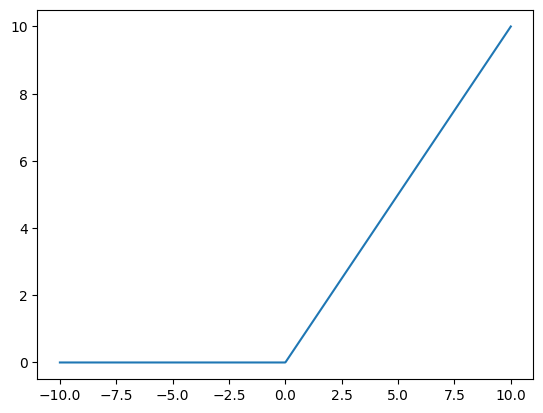

In [ ]:
plt.plot(ls, rely_ls)

## 1.8 Визуализация фильтров

Отобразим то, как нейронная сеть видит изображение, пропущенное через сверточные слои.

In [ ]:
for i in range(len(model.layers)):
    layer = my_vgg.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)


In [ ]:
def show(image, src_model, i) -> None:
    model = keras.Model(inputs=src_model.inputs , outputs=src_model.layers[i].output)
    features = model.predict(image)

    fig = plt.figure(figsize=(20, 15))
    for i in range(1, features.shape[3] + 1):
        plt.subplot(8, 8, i)
        plt.imshow(features[0, :, :, i - 1] , cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


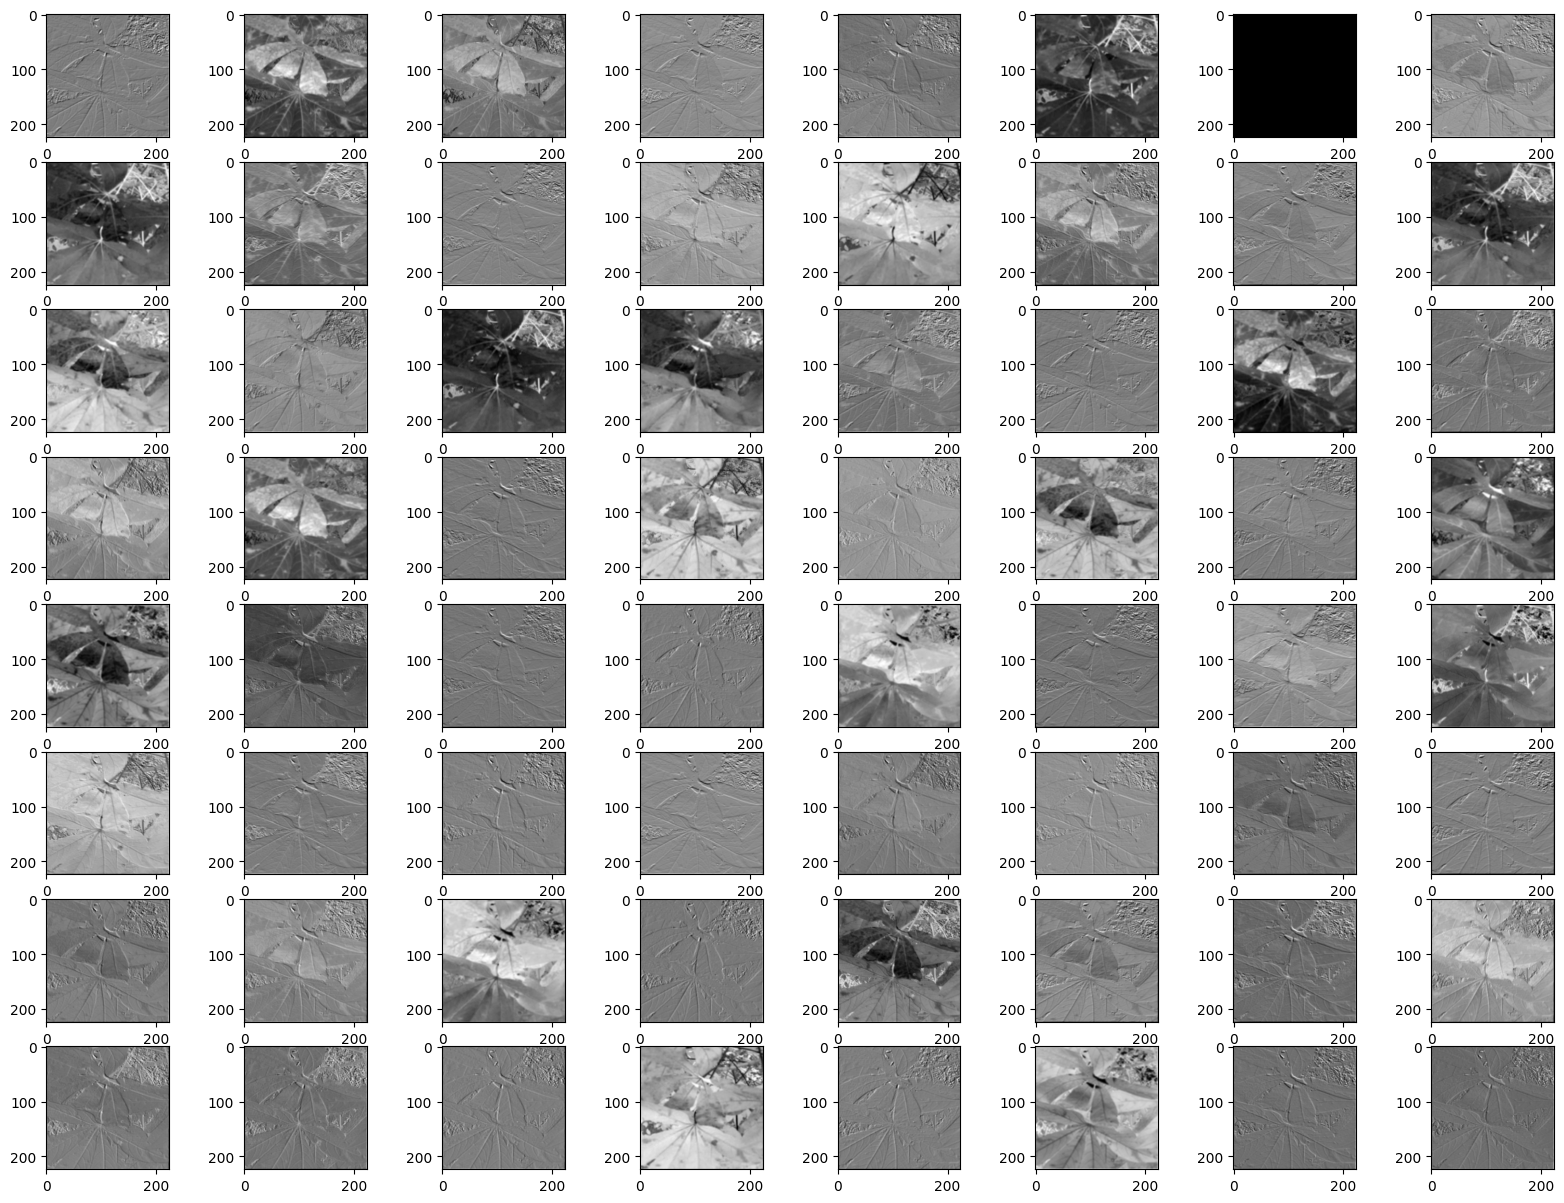

In [ ]:
show(np.array([test_image]), my_vgg, 1)

# Задание 2

## 2.1 Подготовка данных

Откроем файл с соответствием сегментов к цветам на карте.

In [ ]:
df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
df

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [ ]:
X_PATH = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
Y_PATH = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic'

In [ ]:
CLASSES = df.name.to_list()
CLASSES

['unlabeled',
 'paved-area',
 'dirt',
 'grass',
 'gravel',
 'water',
 'rocks',
 'pool',
 'vegetation',
 'roof',
 'wall',
 'window',
 'door',
 'fence',
 'fence-pole',
 'person',
 'dog',
 'car',
 'bicycle',
 'tree',
 'bald-tree',
 'ar-marker',
 'obstacle',
 'conflicting']

In [ ]:
from os import walk

In [ ]:
X = []
for (dirpath, dirnames, filenames) in walk(X_PATH):
    X.extend(filenames)
    break
X = list(map(lambda name: f'{X_PATH}/{name}', X))
X.sort()

In [ ]:
Y = []
for (dirpath, dirnames, filenames) in walk(Y_PATH):
    Y.extend(filenames)
    break
Y = list(map(lambda name: f'{Y_PATH}/{name}', Y))
Y.sort()

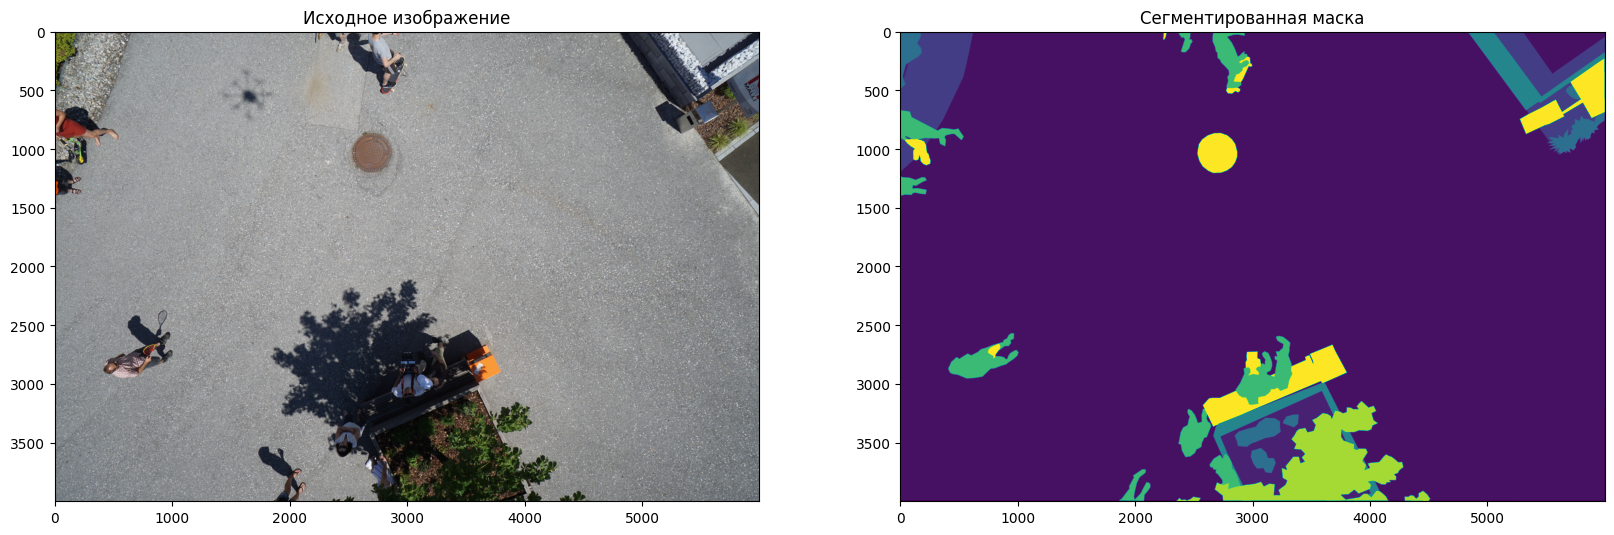

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(np.asarray(Image.open(X[0])));
ax[0].set_title('Исходное изображение');

ax[1].imshow(np.asarray(Image.open(Y[0])));
ax[1].set_title('Сегментированная маска');

## 2.2 Подготовка датасета

Разделим данные на обучающую и тестовую выборки

In [ ]:
train_size = int(0.8 * len(X))
train_size

320

In [ ]:
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class CityDataset(Dataset):
    def __init__(self, image_directory_list: list[str], mask_directory_list: list[str], transformations: list = None):
        self.image_directory_list = image_directory_list
        self.mask_directory_list = mask_directory_list
        self.transformations = transformations

    def __len__(self):
        return len(self.image_directory_list)

    def __getitem__(self, idx):
        image_path = self.image_directory_list[idx]
        mask_path = self.mask_directory_list[idx]

        image = np.asarray(Image.open(image_path))
        mask = np.asarray(Image.open(mask_path))

        image = image.astype(np.float32) / 255.0

        if self.transformations is not None:
            transformed = self.transformations(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


transformations = A.Compose([
    A.LongestMaxSize(max_size=768),
    ToTensorV2()
])

In [ ]:
dataset = CityDataset(X_train, Y_train, transformations)

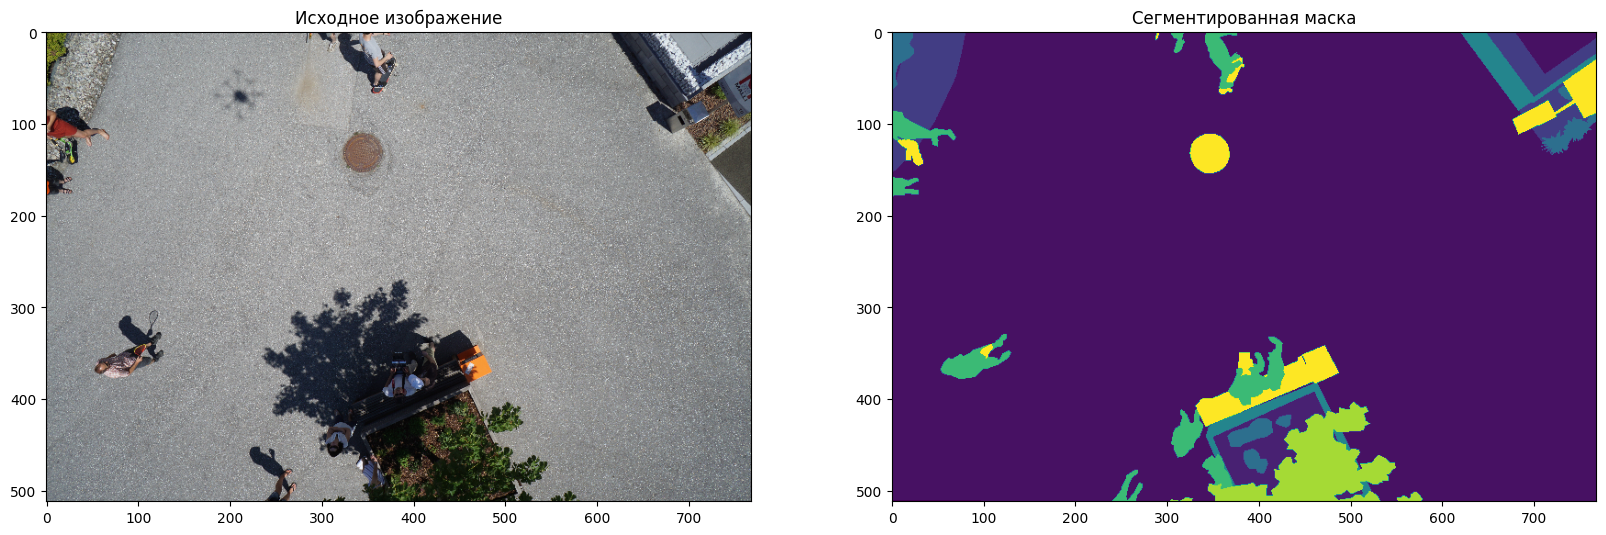

In [ ]:
img, mask = dataset[0]

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Исходное изображение');

ax[1].imshow(mask);
ax[1].set_title('Сегментированная маска');

In [ ]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset, batch_size=8)

## 2.3 Обучение моделей

In [ ]:
! pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 874.6 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5eb96ce275c43536ca85166ea703df9756c522538614ea9b3056fed5c61995b4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c4408a92ca0acdc9c7a7438446f0b6c1e9c3c7cbf13e5dc13878547c1bf68248
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, FPN
import torch.nn as nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def draw_predict(model: nn.Module, image_path: str, true_mask_path: str, transformation) -> None:
    image = np.asarray(Image.open(image_path))
    image = image.astype(np.float32) / 255.0
    true_mask = np.asarray(Image.open(true_mask_path))

    transformed = transformations(image=image, mask=true_mask)

    image = transformed["image"]
    true_mask = transformed["mask"]

    pred_mask = model(image.unsqueeze(0)).detach().softmax(1).argmax(1)[0]

    fig, ax = plt.subplots(1, 3, figsize=(20, 12))

    ax[0].imshow(image.numpy().transpose(1, 2, 0))
    ax[0].set_title('Входное изображение')

    ax[1].imshow(true_mask)
    ax[1].set_title('Истинная маска')

    ax[2].imshow(pred_mask.cpu())
    ax[2].set_title('Предсказанная маска')

### 2.3.1 UNet

#### 2.3.1.1 Обучение модели

In [ ]:
unet = Unet(
    encoder_name='resnet34',
    encoder_depth=5,
    encoder_weights='imagenet',
    classes=len(CLASSES),
).to(device)

In [ ]:
unet = torch.nn.DataParallel(unet, device_ids=[0, 1])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [ ]:
epoch_number = 10

In [ ]:
fit_history = []
for epoch in tqdm(range(epoch_number)):
    loss_values = []
    for x_batch, y_batch in train_dataloader:
        predict = unet(x_batch.to(device))

        loss = criterion(predict, y_batch.to(torch.int64).to(device))
        loss_values.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = np.mean(loss_values)
    fit_history.append(mean_loss)
    print(f'\nЭпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}')

 10%|█         | 1/10 [03:00<27:05, 180.59s/it]


Эпоха 1, среднее значение функции потерь: 2.751858204603195


 20%|██        | 2/10 [05:59<23:58, 179.79s/it]


Эпоха 2, среднее значение функции потерь: 2.2096734672784804


 30%|███       | 3/10 [08:57<20:52, 178.96s/it]


Эпоха 3, среднее значение функции потерь: 1.8374024599790573


 40%|████      | 4/10 [11:55<17:50, 178.37s/it]


Эпоха 4, среднее значение функции потерь: 1.5655068546533584


 50%|█████     | 5/10 [14:55<14:55, 179.11s/it]


Эпоха 5, среднее значение функции потерь: 1.3689134061336516


 60%|██████    | 6/10 [17:53<11:55, 178.79s/it]


Эпоха 6, среднее значение функции потерь: 1.2266231223940849


 70%|███████   | 7/10 [20:51<08:55, 178.52s/it]


Эпоха 7, среднее значение функции потерь: 1.1097710743546485


 80%|████████  | 8/10 [23:47<05:55, 177.55s/it]


Эпоха 8, среднее значение функции потерь: 1.0095481663942336


 90%|█████████ | 9/10 [26:39<02:55, 175.75s/it]


Эпоха 9, среднее значение функции потерь: 0.9262358471751213


100%|██████████| 10/10 [29:31<00:00, 177.10s/it]


Эпоха 10, среднее значение функции потерь: 0.8563354358077049


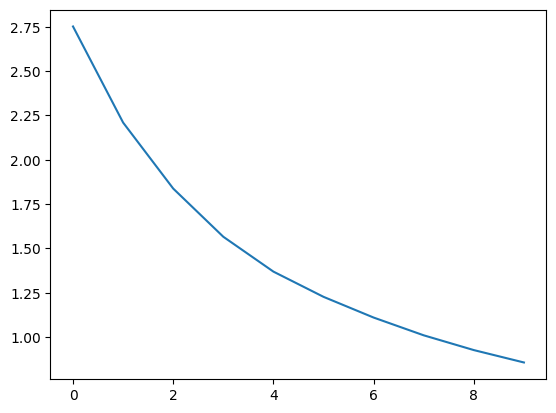

In [ ]:
plt.plot(fit_history)

#### 2.3.1.1 Получение предсказания

In [ ]:
transformations = A.Compose([
    A.Resize(1376, 2048),
    ToTensorV2()
])

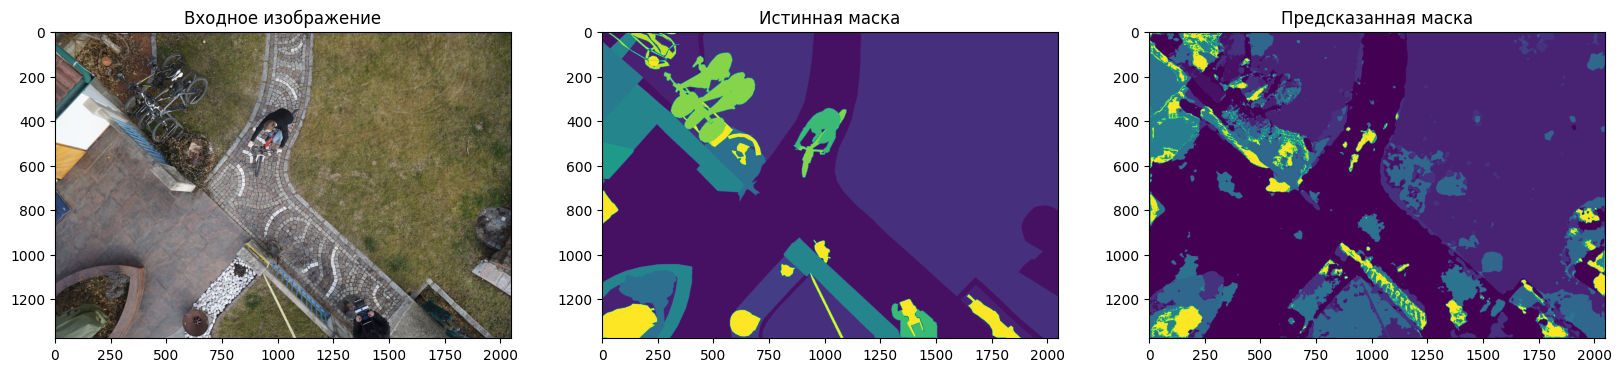

In [ ]:
draw_predict(unet, X_test[0], Y_test[0], transformations)

### 2.3.2 FPN

#### 2.3.2.1 Обучение модели

In [ ]:
fpn = FPN(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    classes=len(CLASSES),
).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 228MB/s] 


In [ ]:
fpn = torch.nn.DataParallel(fpn, device_ids=[0, 1])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fpn.parameters(), lr=0.0001)

In [ ]:
epoch_number = 10

In [ ]:
fit_history = []
for epoch in tqdm(range(epoch_number)):
    loss_values = []
    for x_batch, y_batch in train_dataloader:
        predict = fpn(x_batch.to(device))

        loss = criterion(predict, y_batch.to(torch.int64).to(device))
        loss_values.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = np.mean(loss_values)
    fit_history.append(mean_loss)
    print(f'Эпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}\n')

 10%|█         | 1/10 [03:43<33:33, 223.70s/it]

Эпоха 1, среднее значение функции потерь: 1.9722612038254739



 20%|██        | 2/10 [06:57<27:27, 205.90s/it]

Эпоха 2, среднее значение функции потерь: 0.9711851388216018



 30%|███       | 3/10 [10:10<23:22, 200.36s/it]

Эпоха 3, среднее значение функции потерь: 0.7168300710618496



 40%|████      | 4/10 [13:24<19:46, 197.68s/it]

Эпоха 4, среднее значение функции потерь: 0.5711714588105679



 50%|█████     | 5/10 [16:42<16:28, 197.63s/it]

Эпоха 5, среднее значение функции потерь: 0.4944989442825317



 60%|██████    | 6/10 [19:57<13:07, 196.91s/it]

Эпоха 6, среднее значение функции потерь: 0.4349317967891693



 70%|███████   | 7/10 [23:12<09:48, 196.19s/it]

Эпоха 7, среднее значение функции потерь: 0.39701115638017653



 80%|████████  | 8/10 [26:27<06:31, 195.79s/it]

Эпоха 8, среднее значение функции потерь: 0.3655013978481293



 90%|█████████ | 9/10 [29:43<03:15, 195.80s/it]

Эпоха 9, среднее значение функции потерь: 0.34020663872361184



100%|██████████| 10/10 [32:53<00:00, 197.38s/it]

Эпоха 10, среднее значение функции потерь: 0.32197468020021913



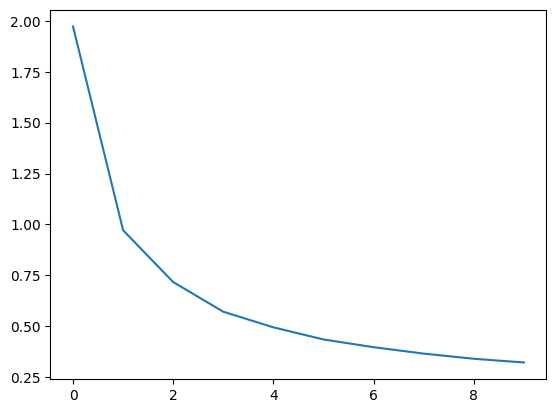

In [ ]:
plt.plot(fit_history)

#### 2.3.1.1 Получение предсказания

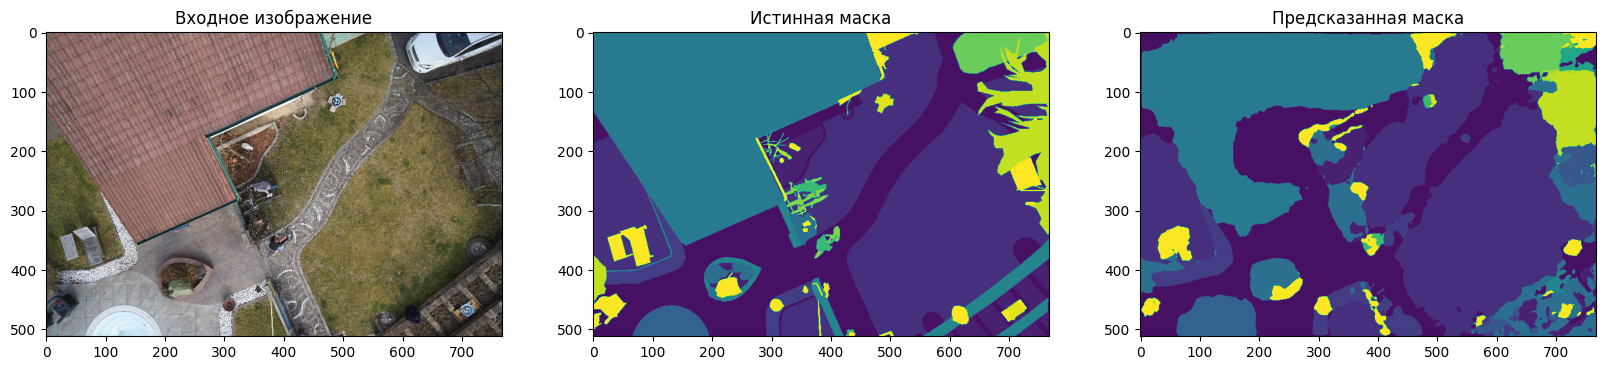

In [ ]:
draw_predict(fpn, X_test[10], Y_test[10], transformations)